In [11]:

# Assignment 3
# Determining and removing drawbacks of exponential and running mean.
# Team 2:
#     Ekaterina Karmanova
#     Timur Chikichev
#     Iaroslav Okunevich
#     Nikita Mikhailovskiy
#
# Skoltech, 04.10.2019

import os
try:
	os.chdir(os.path.join(os.getcwd(), 'lab3'))
	print(os.getcwd())
except:
	pass

import numpy as np
from functools import partial

import smoothing as sm
from walking_model import Random_walking_model, rvm_alpha
from noised_signal import Measurements

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# from plotting import new_plot, draw_plots

def draw_plots(plots=[], show=False):
    for pi, plabel in plots:
        plt.plot(pi, label=plabel)

    plt.legend()
    if show:
        plt.show()


def new_plot(title, xl, yl, plots=[], show=False):
    figure(num=None, figsize=(10, 5), dpi=200,
           facecolor='w', edgecolor='k')
    plt.title(title)
    plt.ylabel(yl)
    plt.xlabel(xl)
    if plots:
        draw_plots(plots, show)

In [13]:
def Trajectory(size, X0, t, sigma_a):
    acc = np.random.normal(X0[2], sigma_a, size - 1)
    vel = Random_walking_model.TrueTrajectory(X0[1], acc * t)
    trajectory = Random_walking_model.TrueTrajectory(
        X0[0], vel[:-1]*t + acc * t * t / 2)
#     new_plot('Plot result', 'Measurement', 'Points',
#     [
#         [acc, 'Acceleration'],
#         [vel, 'Velosity']
#     ], show = False)
#     plt.savefig(fname='Trajectory.png')
    return trajectory

initial_vals = [5, 1, 0]
size = 200
T = 1
sigma_a = 0.2

gen_Trajectory = partial(Trajectory, size, initial_vals, 1, sigma_a)

In [14]:
traject = gen_Trajectory()

sigma_noise = 20
Known_vals = Measurements(traject, sigma_noise)
z = Known_vals.z

# RM = sm.RunningMean(z, 1)

In [15]:
T = 1

# input matrix
G = np.matrix([[T**2/2], [T]])

# obseravation matrix
H = np.matrix([1, 0])

# transition matrix
F = np.matrix([[1, T],[0, 1]])

In [16]:
# covariance matrix Q of state noise Ga i−1
q_pred = np.dot(G, G.T) * sigma_a**2
# sigma_a
print(q_pred, G)

[[0.01 0.02]
 [0.02 0.04]] [[0.5]
 [1. ]]


In [17]:
# covariance matrix R of measurements noise η i

# Dimension of covariance
# matrix R is determined by a number of state vector 
# components that are measured. In this
# particular case, only coordinate x i is measured

R = sigma_noise**2

In [18]:
# initial state vector
X0 = np.matrix([[2], [0]])

# initial filtration error covariance matrix
P00 = np.matrix(np.eye(2) * 10000)
print(X0, P00)

[[2]
 [0]] [[10000.     0.]
 [    0. 10000.]]


In [19]:
def recurrent_calman_filter(X0, P0, z, F, Q, H, R):
    """
    Recurrent algorithm of Kalman filter
    X0 - initial estimate of state vector
    P0 - initial filtration error covariance matrix
    H - obseravation matrix
    F - transition matrix
    Q - covariance matrix of state noise
    R - covariance matrix of measurements noise η
    """
    F7 = np.eye(2)
    for i in range(7):
        F7 = F7.dot(F)
#     print(F7)
    

    def kalman_predict(x_filt, p_filt, F, Q):
#         print("F:{}, x_filt:{}, p_filt:{}".format(F, x_filt, p_filt))
        x_pred = np.dot(F, x_filt)    
        p_pred = np.dot(F.dot(p_filt), F.T) + Q
#         print(x_filt, p_filt, x_pred, p_pred)
        return x_pred, p_pred

    def kalman_predict7(x_filt, p_filt, Q):
        x_pred7 = np.dot(F7, x_filt)
        p_pred7 = np.dot(F.dot(p_filt), F7.T) + Q
        return x_pred7, p_pred7

    def kalman_filter(x_pred, p_pred, z, H, R):
        try:
            x = np.dot(H.dot(p_pred), H.T) + R
            inverse = np.linalg.inv(x)
        except np.linalg.LinAlgError:
            return None
        else:
            ki = np.dot(p_pred, H.T).dot(inverse)
#             print("z:{}, H: {} x_pred{}, ki{}".format(z,H, x_pred, ki))
            residual = np.dot(ki, np.subtract(z, H.dot(x_pred)) )
            x_filt = x_pred + residual
            p_filt = (np.subtract(np.eye(2), np.dot(ki, H)).dot(p_pred))
            return x_filt, p_filt, ki[0][0]
    
    x_filt = X0
    p_filt = P0

    gain = []
    smoothed = []
    ex7 = []
    
    diag1 = []
    for i in range(size):
        x_pred, p_pred = kalman_predict(x_filt, p_filt, F, q_pred)
        x_pred7 = x_filt.dot(F7)
        ex7.append(x_pred7[0][0])
        
        x_filt, p_filt, k = kalman_filter(x_pred, p_pred, z[i], H, R)
        smoothed.append(x_filt)
        gain.append(k)
        diag1.append(np.sqrt(p_filt[0,0]))
    return smoothed, gain, diag1, ex7

# Plot results including 
# true trajectory, measurements, 
# filtered estimates of state vector X i .
smoothed, gain, daig1, ex7 = \
recurrent_calman_filter(X0[:2], P00, z, F, q_pred, H, R, True)

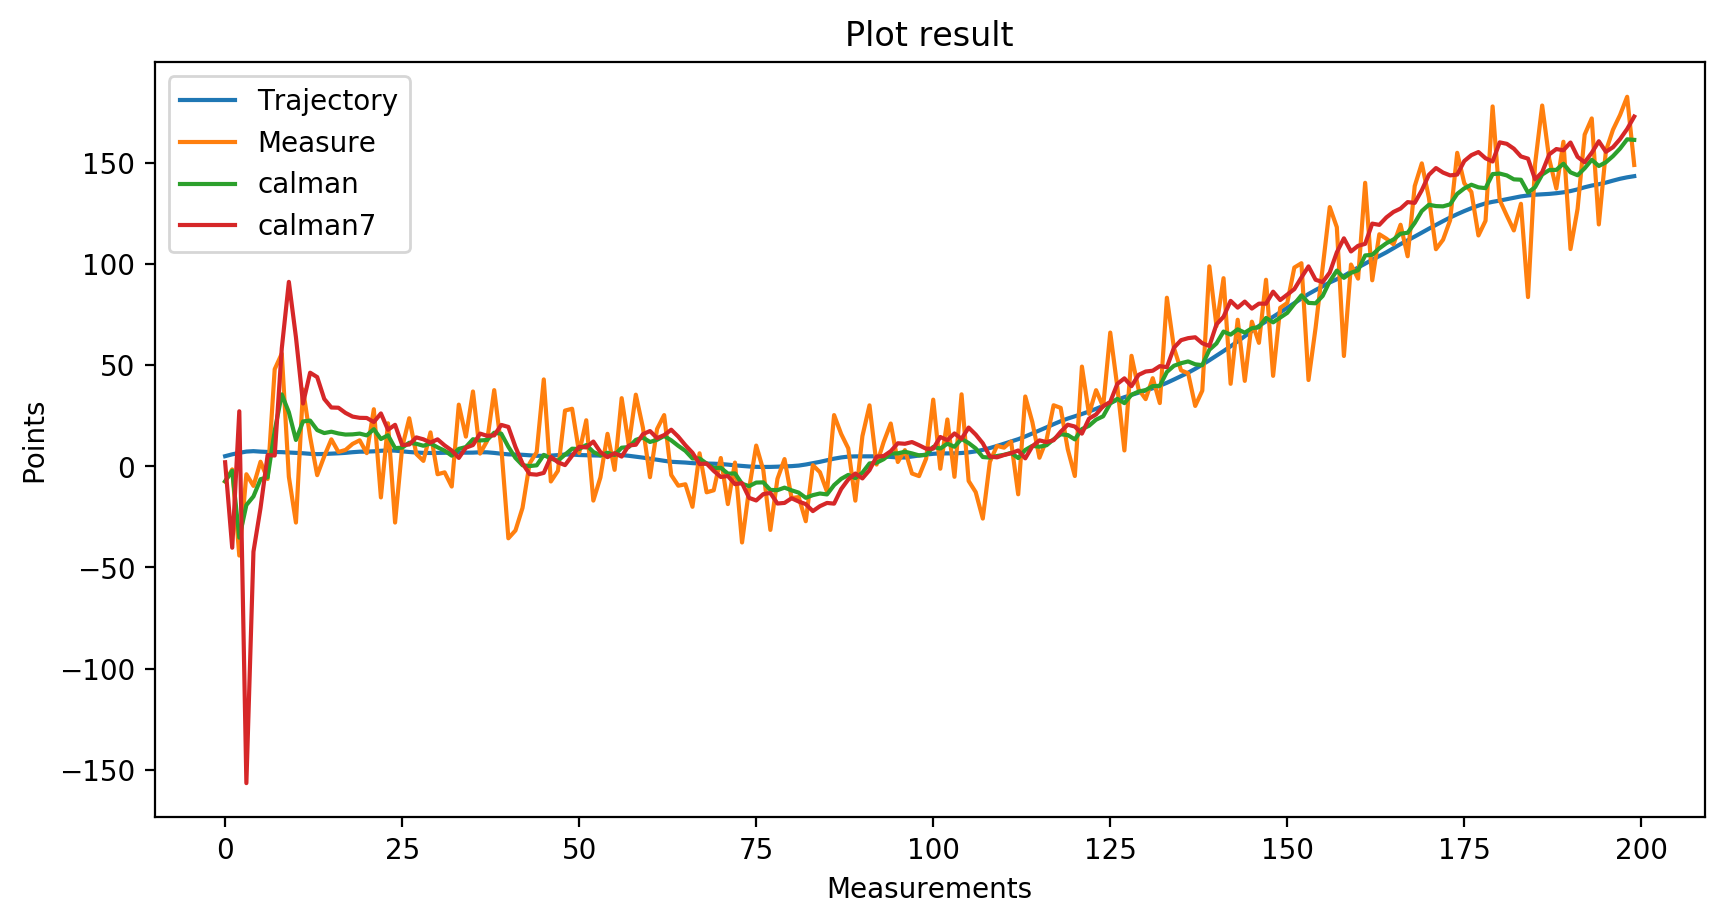

In [20]:
xs = np.array(smoothed).squeeze()
x7s = np.array(ex7).squeeze()

new_plot('Plot result',
        'Measurements', 'Points', [
            [traject, 'Trajectory'],
            [z, 'Measure'],
            [xs[:,0], 'calman'],
            [x7s[:,0], 'calman7']
        ], show = False)
plt.savefig(fname = 'running mean 1.png')

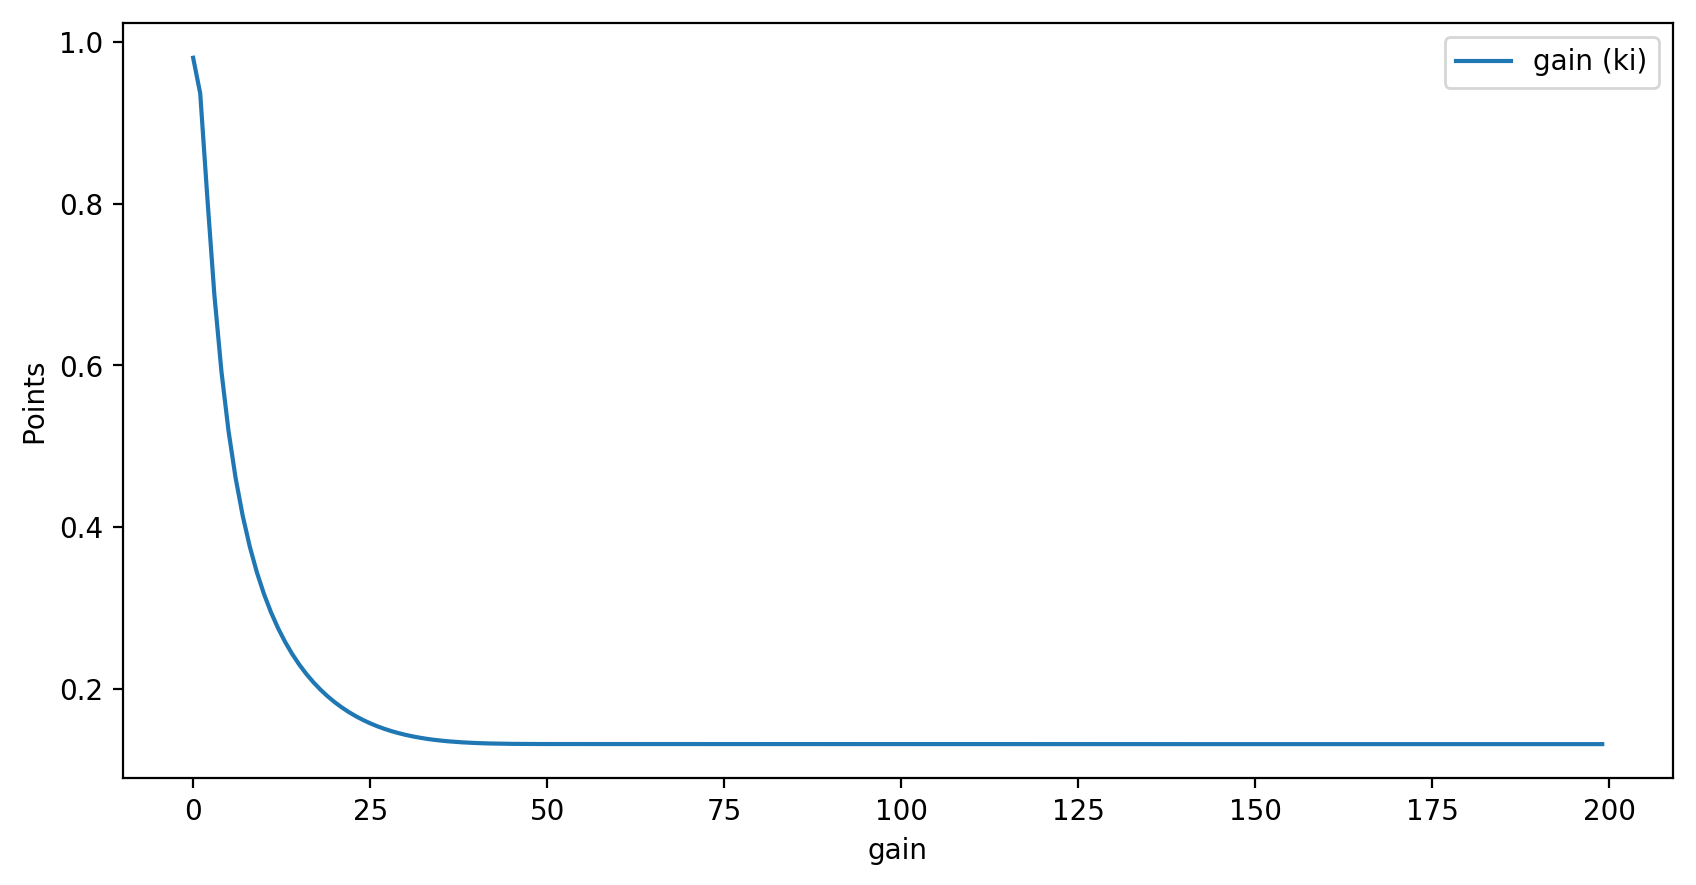

In [21]:
gs = np.array(gain).squeeze()

new_plot('',
        'gain', 'Points', [
            [gs, 'gain (ki)']
        ], show = True)
# plt.savefig(fname = 'running mean 1.png')

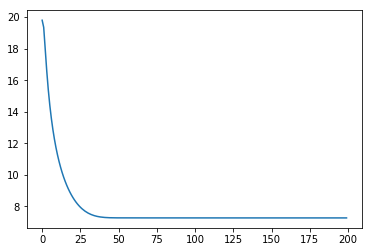

In [22]:
# To analyze filtration error covariance matrix P i,i over observation period, please also make
# another plot of square root of its first diagonal element corresponding to standard deviation
# of estimation error of coordinate x i .
daig1_plot = np.array(daig1).squeeze()

# Verify whether filter gain K and filtration error covariance matrix become constant very
# quickly. It means that in conditions of a trajectory disturbed by random noise we cannot
# estimate more than established limit of accuracy due to uncertainty.

plt.plot(daig1_plot)
plt.show()

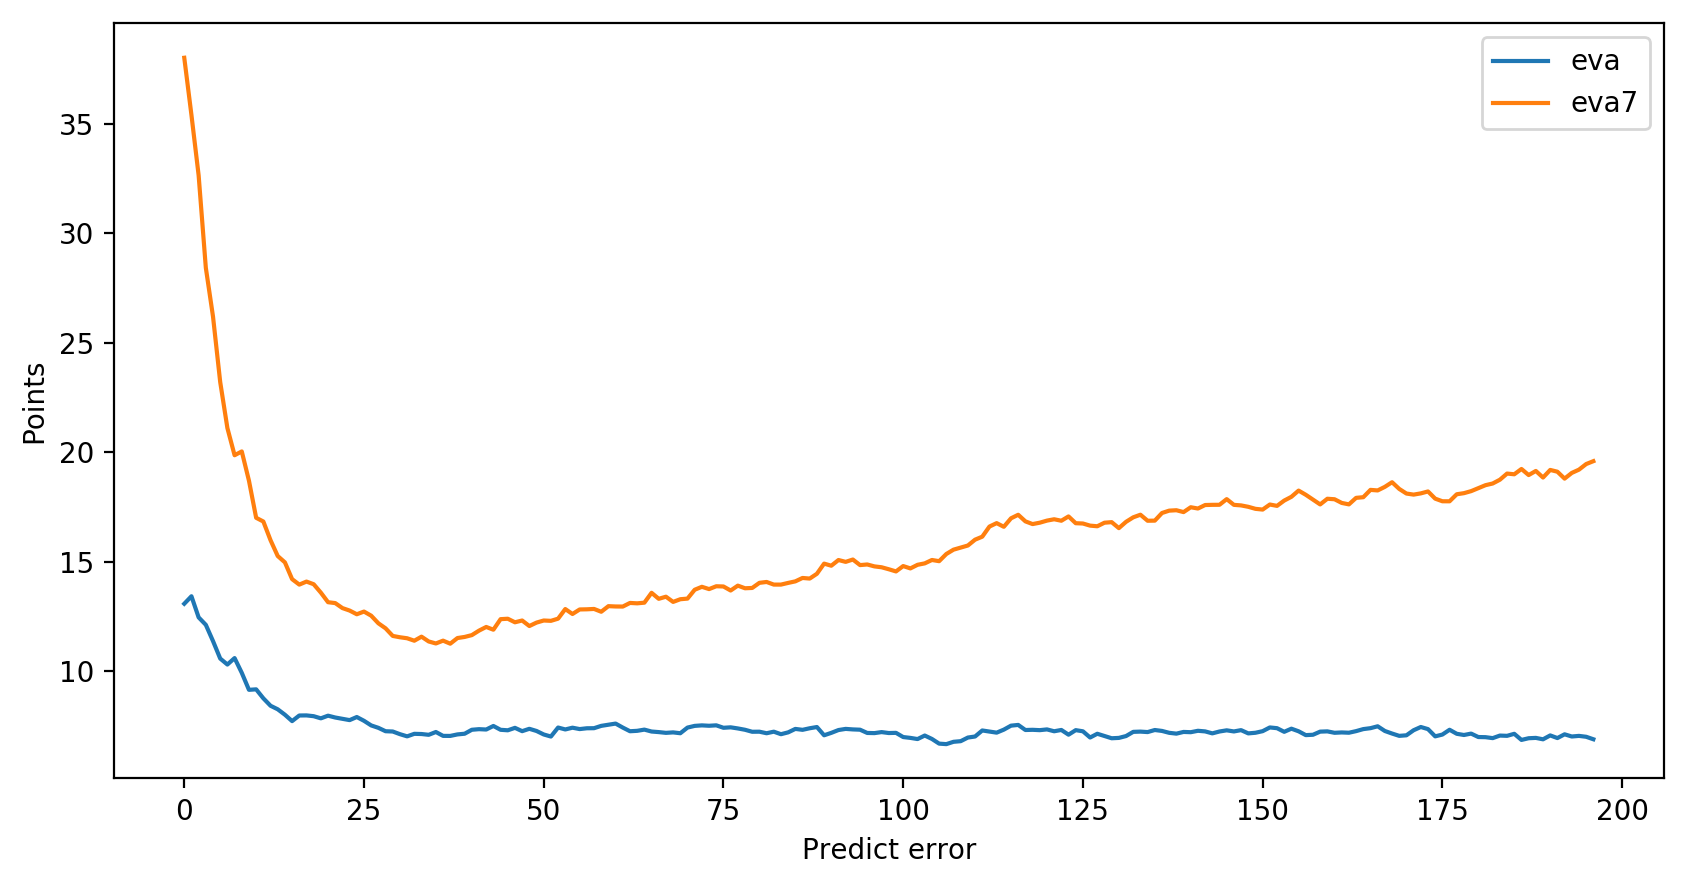

In [27]:
m_iter = 500
errs = []
errs7 = []

for i in range(m_iter):
    traject = gen_Trajectory()
    kvals = Measurements(traject, sigma_noise)
    z = kvals.z
    
    smoothed, gain, daig1, ex7 = \
    recurrent_calman_filter(X0, P00, kvals.z, F, q_pred, H, R, True)
    z_res = np.array(smoothed).squeeze()[:,0]
    z_res7 = np.array(ex7).squeeze()[:,0]
    
    errs.append([(traject - z_res)**2])
    errs7.append([(traject - z_res7)**2])
    
e = np.array(errs).T
e7 = np.array(errs7).T

eva = [np.sqrt(np.sum(e[i,:])) for i in range(3,size)] / np.sqrt(m_iter - 1)
eva7 = [np.sqrt(np.sum(e7[i,:])) for i in range(3,size)] / np.sqrt(m_iter - 1)

new_plot('',
        'Predict error', 'Points', [
            [eva, "eva"],
            [eva7, "eva7"]
        ], show = True)
# plt.savefig(fname = 'running mean 1.png')
    
# new_plot('Plot result',
#         'Measurements', 'Points', [
#             [traject, 'Trajectory'],
#             [z, 'Measure'],
#             [xs[:,0], 'calman'],
#             [z_recurrent, 'calman after {} iterations'.format(m_iter)]
#         ], show = False)
# plt.savefig(fname = 'running mean 1.png')

[[2]
 [0]] [[100.   0.]
 [  0. 100.]]


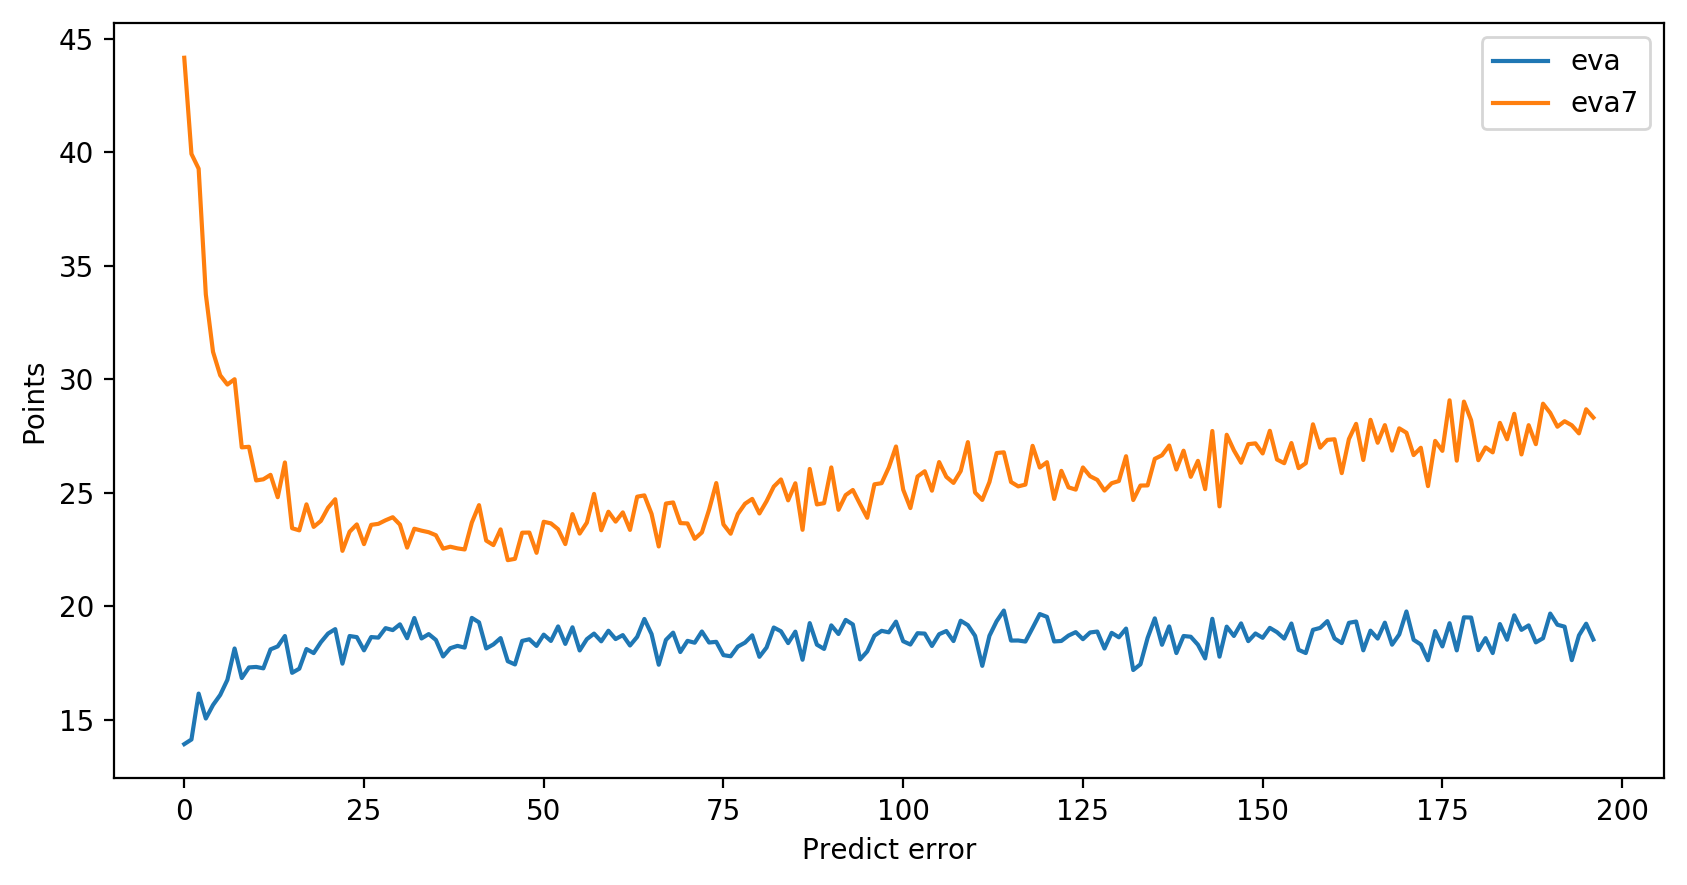

In [24]:
P00 = np.matrix(np.eye(2) * 100)
print(X0, P00)

errs = []
errs7 = []

for i in range(m_iter):
    traject = gen_Trajectory()
    kvals = Measurements(traject, sigma_noise)
    z = kvals.z
    
    smoothed, gain, daig1, ex7 = \
    recurrent_calman_filter(X0, P00, kvals.z, F, q_pred, H, R, True)
    z_res = np.array(smoothed).squeeze()[:,0]
    z_res7 = np.array(ex7).squeeze()[:,0]
    
    errs.append([(kvals.z - z_res)**2])
    errs7.append([(kvals.z - z_res7)**2])
    
e = np.array(errs).T
e7 = np.array(errs7).T

eva = [np.sqrt(np.sum(e[i,:])) for i in range(3,size)] / np.sqrt(m_iter - 1)
eva7 = [np.sqrt(np.sum(e7[i,:])) for i in range(3,size)] / np.sqrt(m_iter - 1)

new_plot('',
        'Predict error', 'Points', [
            [eva, "eva"],
            [eva7, "eva7"]
        ], show = True)

In [25]:
# Plot results including 
# true trajectory, measurements, 
# filtered estimates of state vector X i .
print(traject.shape)

new_plot('Plot result',
        'Measurements', 'Points', [
            [traject, 'Trajectory'],
            [z, 'Measure']
            [a, 'calman']
        ], show = False)
plt.savefig(fname = 'running mean 1.png')


# Run filter several times to see that 
# estimation results are different with every new trajectory.

(200,)


NameError: name 'a' is not defined